```
Muris Saab
ADS509 - Assignment 5.1
University of San Diego
```

# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [22]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()

In [23]:
# add any additional libaries you need here
import nltk
nltk.download('brown')

import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\muriss\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [24]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [25]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [26]:
categories = ['editorial','government','news','romance','hobbies'] 
category_list = []
file_ids = []
texts = []
for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 
df.shape

(166, 3)

In [27]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

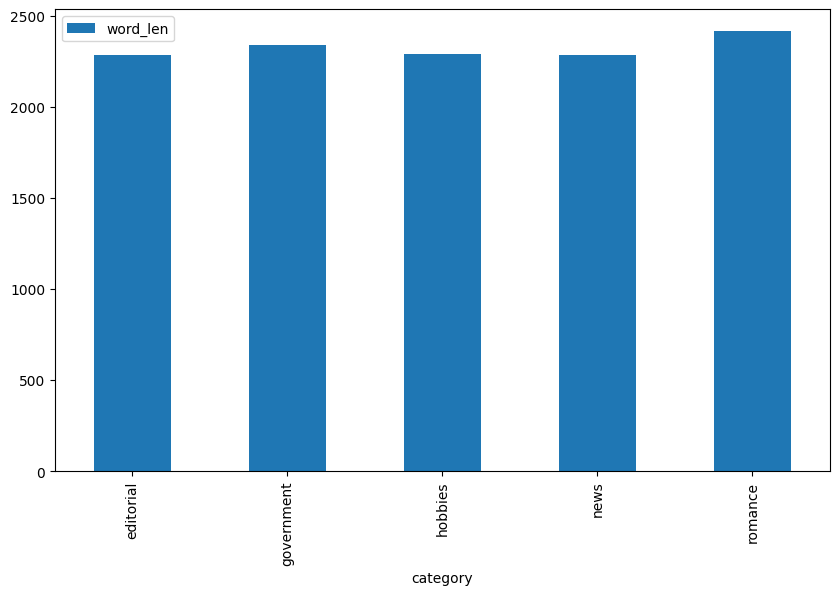

In [28]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [29]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

C:\Users\muriss\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [30]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: 

**count_text_vectors**: contains the raw frequency counts of words in the documents. Each row corresponds to a document, and each column corresponds to a unique word (or term) from the corpus that meets the specified frequency criteria.

**tfidf_text_vectors**: contains the TF-IDF (Term Frequency-Inverse Document Frequency) values for each word in the documents. It transforms the raw frequency counts into weights that reflect both the frequency of the word in a specific document and its relative importance across all documents.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [31]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [32]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [33]:
# Your code here
df['nmf_topic'] = W_text_matrix.argmax(axis=1)
nmf_vs_brown = pd.crosstab(df['nmf_topic'], df['category'])
nmf_vs_brown

category,editorial,government,hobbies,news,romance
nmf_topic,,,,,
0,20,4,0,8,0
1,4,0,8,0,29
2,2,26,26,11,0
3,0,0,1,17,0
4,1,0,1,8,0


Q: How does your five-topic NMF model compare to the original Brown categories? 

A:

Topic 3 is predominantly composed of news documents (17 out of 18 documents). This shows that the NMF model successfully captured a theme closely related to news reporting, which strongly aligns with the news category in the Brown corpus.

Topic 2 is a mix of government, hobbies, and news documents. This suggests that the NMF model uncovered a topic that blends government-related and hobby-related themes, with some overlap with news. This could indicate that these documents, though categorized differently in the Brown corpus, share underlying thematic elements (e.g., public policy or practical information).

Topic 1 is heavily dominated by romance documents (29 out of 41 documents), with some contributions from hobbies and editorial. This shows that the NMF model has captured a narrative or personal interaction style that is typical in romance but has some overlap with hobbies and editorial content.

Topic 0 shows a significant overlap between editorial and news categories. It suggests that editorials and certain news articles share thematic elements, such as opinion pieces, discussions of current events, or political commentary, which the NMF model grouped together.

The NMF model does align with the original categories to an extent, particularly for news and romance, where the topics are well represented by documents from these categories.

The NMF model also highlights some blending of themes across categories, particularly in editorial, government, and hobbies. This suggests that while the Brown corpus categories are discrete, the thematic content of documents within these categories can overlap.




## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [34]:
# Your code here

from sklearn.decomposition import TruncatedSVD

lsa_text_model = TruncatedSVD(n_components=5, random_state=314)
W_lsa_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)
df['lsa_topic'] = W_lsa_matrix.argmax(axis=1)
lsa_vs_brown = pd.crosstab(df['lsa_topic'], df['category'])
lsa_vs_brown


category,editorial,government,hobbies,news,romance
lsa_topic,,,,,
0,27,30,36,34,21
1,0,0,0,0,8
3,0,0,0,3,0
4,0,0,0,7,0


Q: How does your five-topic LSA model compare to the original Brown categories? 

Topic 0 captures documents from all categories: editorial, government, hobbies, news, and romance. This suggests that LSA identifies broad themes shared across many categories rather than isolating specific thematic content. In contrast, the Brown corpus categories represent distinct genres or domains of text, which LSA does not fully separate.

Topic 1 captures only 8 romance documents, which is a subset of the full romance category. While LSA does identify a romance-specific theme, it fails to capture the majority of the romance-related documents, suggesting it does not effectively isolate this genre.

Topics 3 and 4 capture a small number of news documents, but they are fragmented across these topics. This indicates that LSA struggles to consolidate all the news content into a single cohesive topic, likely due to the shared vocabulary and structure between news and other categories.

The LSA model tends to group documents from multiple categories into a single topic (Topic 0), indicating that it captures more general patterns in the text (e.g., common word usage) rather than the specific distinctions between genres present in the Brown corpus.

Brown Categories: The Brown corpus has clear-cut categories like editorial, government, hobbies, news, and romance, which represent distinct types of text with specific styles, vocabularies, and themes.

LSA Model: The LSA model, on the other hand, tends to merge documents from different categories into broader topics, particularly in Topic 0. This suggests that LSA is picking up on overarching patterns rather than respecting the categorical boundaries defined in the corpus.

In [35]:
# call display_topics on your model
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())



Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: The LSA model captures some clear topics (e.g., sports and social activities) but also creates broader, more blended topics that combine different genres (e.g., dialogue, political figures, and titles). This reinforces the idea that LSA tends to generalize topics more than NMF, which resulted in clearer, more distinct themes aligned with the original Brown corpus categories.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [ ]:
# Fit your LDA model here
import gensim
import pyLDAvis.gensim

texts = [text.split() for text in df['text']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, random_state=314, passes=15)
lda_vis_data = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis_data)


Intertopic Distance Map:
- Topic Separation: The visualization shows that Topics 1, 2, and 3 have considerable overlap, while Topics 4 and 5 are more distinct. This suggests that Topics 1, 2, and 3 might cover related themes or share substantial common vocabulary. Topics 4 and 5, being more isolated, could represent more unique or distinct themes that aren't as prevalent in other topics.
- Size of Topics: The size of each circle indicates the prevalence of the topic. It seems that Topic 1 is the largest, suggesting it encompasses themes or words that are more common across the documents.

Top-30 Most Salient Terms (for the selected Topic 1):
- Common Words: The terms displayed are very common (e.g., "the", "of", "and", "to"), which can often be the case in raw frequency lists. These words might not provide much insight into the specific themes or subjects of the topic because they are general stopwords.
- Lambda Value: The relevance metric (λ) is set to 1, which currently emphasizes the terms' overall frequency within the topic rather than their distinctiveness. Adjusting the lambda value closer to 0 might reveal more unique and informative words for each topic, which would be more useful for interpreting the specific themes.

In [16]:
# Call `display_topics` on your fitted model here

def display_gensim_topics(model, num_words=5):
    for idx, topic in enumerate(model.print_topics(num_topics=-1, num_words=num_words)):
        print(f"Topic {idx + 1}:\nWords: {topic}\n")
display_gensim_topics(lda_model)


Topic 1:
Words: (0, '0.058*"," + 0.045*"the" + 0.043*"." + 0.025*"and" + 0.025*"of"')

Topic 2:
Words: (1, '0.036*"the" + 0.036*"." + 0.034*"," + 0.028*"of" + 0.019*"in"')

Topic 3:
Words: (2, '0.000*"." + 0.000*"the" + 0.000*"and" + 0.000*"," + 0.000*"to"')

Topic 4:
Words: (3, '0.060*"the" + 0.041*"," + 0.039*"." + 0.032*"of" + 0.025*"to"')

Topic 5:
Words: (4, '0.033*"the" + 0.028*"." + 0.021*"of" + 0.021*"and" + 0.020*","')



Q: What inference do you draw from the displayed topics for your LDA model? 

A: 

- Topic 1: This topic is heavily weighted towards punctuation and very common English words, which suggests that it might not represent a coherent thematic topic. Instead, it captures frequent structural elements of the English language.
- Topic 2: This topic is dominated by common stopwords and punctuation. It lacks specific thematic content and reflects generic textual structure.
- Topic 3: This topic also shows all zero or negligible weights (indicated by the "0.000*"), which can happen if the words are too common across all documents to provide any distinctive value for topic differentiation.
- Topic 4: This topic is composed mostly of common English stopwords and punctuation. There's no distinct thematic element evident from the top words.
- Topic 5: This topic continues the pattern of the others, dominated by stopwords and punctuation, indicating a lack of specific, differentiated themes.


Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

In [17]:
doc_topic_distrib = [lda_model.get_document_topics(bow) for bow in corpus]
dominant_topics = [sorted(topics, key=lambda x: x[1], reverse=True)[0][0] for topics in doc_topic_distrib]
df['dominant_topic'] = dominant_topics
category_topic_distribution = pd.crosstab(df['category'], df['dominant_topic'])
print(category_topic_distribution)


dominant_topic   0  1   3  4
category                    
editorial        7  0  20  0
government       6  3  19  2
hobbies         11  7  14  4
news            16  5  23  0
romance         29  0   0  0


- Topic 0: Has a broad distribution across multiple categories with romance showing a particularly strong alignment, where all 29 romance articles are assigned to this topic. This indicates that Topic 0 may have captured themes or styles particularly prevalent in romance texts.

- Topic 1: Shows minimal alignment with very few documents overall; however, it captures a small portion of government and hobbies articles. This suggests a more niche theme that resonates with only specific aspects of these categories.

- Topic 3: The most evenly distributed across categories, indicating that it likely captures a more generic or broadly applicable theme that spans multiple types of content. It's particularly dominant in editorial, government, and news categories, suggesting themes of formal or informative content.

- Topic 4: This topic is less represented but captures a few documents from government and hobbies. The sparse distribution suggests a very niche or less dominant theme within these categories.

In [21]:
import pyLDAvis.gensim_models

# Prepare the LDA visualization using the gensim_models interface
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)




Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: <!-- Your answer here --> 

- The map shows topics 1, 2, and 3 overlapping significantly, which suggests these topics share a lot of common vocabulary or discuss related themes. This overlap might indicate that the distinctions between the themes these topics represent are subtle.
- Topics 4 and 5 appear more distinct and separate from the cluster of the first three topics. This suggests that the themes captured by topics 4 and 5 are more unique or less related to the themes of topics 1, 2, and 3.
- The size of the circles represents the relative document proportions within each topic. Topic 1 is notably larger than the others, indicating it comprises a higher proportion of the corpus.
- The marginal topic distribution curve along the bottom left suggests that most topics occupy a moderate percentage of the document corpus, with no single topic dominating. This distribution can help in understanding the balance of topic coverage across the corpus.
- Term Frequency: The graph shows a list of words that are very common in the English language, such as "the", "of", "and", "to", "in", which are typical stopwords. Their high frequency across the documents suggests that either the preprocessing could be adjusted to remove these common terms for more insightful analysis or that the topics are capturing broad linguistic structures rather than specific thematic content.
Adjusting the Relevance Metric (Lambda - λ):
- The current setting of λ=1 emphasizes the terms' frequency over their distinctiveness. This setting might not be ideal for understanding what makes each topic unique. Adjusting λ towards 0 would increase the weight of the terms' distinctiveness within the topic relative to their overall frequency in the corpus, potentially revealing more about the unique aspects of each topic.